Linear SVM accuracy on 2D test: 0.875
RBF SVM accuracy on 2D test: 0.917


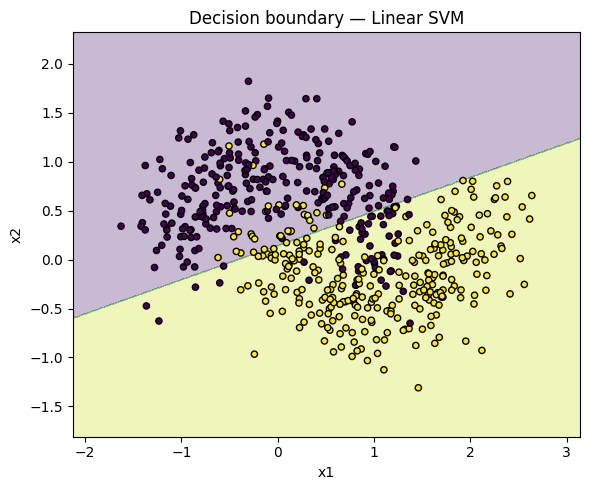

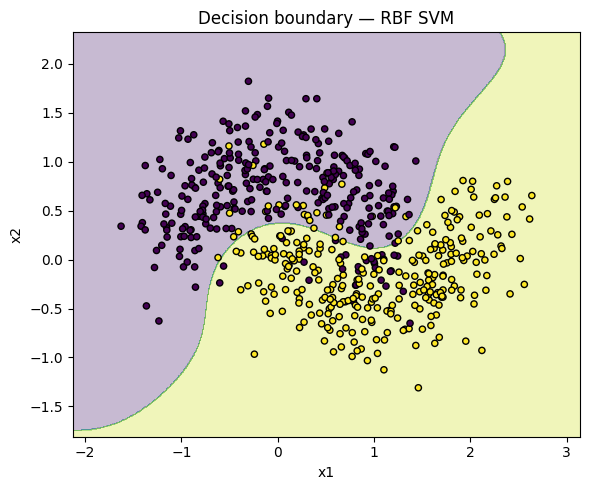

In [1]:
# ---- Imports used for both parts ----
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report,
                             ConfusionMatrixDisplay, RocCurveDisplay)

# ---- Make a 2D dataset ----
X, y = make_moons(n_samples=600, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---- Two pipelines: Linear & RBF ----
linear_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", probability=True, random_state=42))
])

rbf_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", probability=True, random_state=42))
])

linear_svm.fit(X_train, y_train)
rbf_svm.fit(X_train, y_train)

for name, model in [("Linear", linear_svm), ("RBF", rbf_svm)]:
    y_pred = model.predict(X_test)
    print(f"{name} SVM accuracy on 2D test: {accuracy_score(y_test, y_pred):.3f}")

# ---- Helper to plot decision boundary for any pipeline ----
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 500),
        np.linspace(y_min, y_max, 500)
    )
    # The pipeline handles scaling internally
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", s=20)
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

plot_decision_boundary(linear_svm, X, y, "Decision boundary — Linear SVM")
plot_decision_boundary(rbf_svm, X, y, "Decision boundary — RBF SVM")


In [ ]:
# ---- Load real dataset ----
data = load_breast_cancer()
X_bc, y_bc = data.data, data.target

Xtr, Xte, ytr, yte = train_test_split(
    X_bc, y_bc, test_size=0.2, stratify=y_bc, random_state=42
)

# ---- Pipeline: scale -> SVC ----
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True, random_state=42))
])

# ---- Hyperparameter grid for both kernels ----
# C controls margin softness; gamma controls RBF's influence radius
param_grid = [
    {"svc__kernel": ["linear"],
     "svc__C": np.logspace(-3, 3, 7)},
    {"svc__kernel": ["rbf"],
     "svc__C": np.logspace(-3, 3, 7),
     "svc__gamma": np.logspace(-4, 1, 6)}
]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,                # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(Xtr, ytr)

print("Best params:", grid.best_params_)
print(f"Best CV score (train folds): {grid.best_score_:.4f}")

best_model = grid.best_estimator_

# ---- Cross-validation on the whole dataset (robust estimate) ----
cv_scores = cross_val_score(best_model, X_bc, y_bc, cv=5, scoring="accuracy", n_jobs=-1)
print("5-fold CV accuracy (best model):", np.round(cv_scores, 4), " | mean:", cv_scores.mean().round(4))

# ---- Final test set evaluation ----
y_pred = best_model.predict(Xte)
print("\nTest accuracy:", accuracy_score(yte, y_pred).round(4))
print("\nClassification report (test):\n", classification_report(yte, y_pred, target_names=data.target_names))

# ---- Confusion matrix ----
ConfusionMatrixDisplay.from_estimator(best_model, Xte, yte)
plt.title("Confusion Matrix — Best SVM on Breast Cancer")
plt.tight_layout()
plt.show()

# ---- ROC curve & AUC ----
RocCurveDisplay.from_estimator(best_model, Xte, yte)
plt.title("ROC Curve — Best SVM on Breast Cancer")
plt.tight_layout()
plt.show()
